## Task 2. Preprocessing and dataset representation

In [1]:
import pandas as pd

df = pd.read_csv('pubmed_data.csv').dropna(subset=['title', 'abstract', 'relevance']).drop_duplicates(keep='last')


In [2]:
print(df.columns)
print(df.shape)

print('Records with no title:', df[df['title'] == 'No title'].shape[0])
print('Records with no abstract:', df[df['abstract'] == 'No abstract'].shape[0])

missing_data_df = df[(df['title'] == 'No title') | (df['abstract'] == 'No abstract')]
print('Records without title or abstract', missing_data_df.shape[0], '; their positive relevance rate:', missing_data_df['relevance'].sum() / missing_data_df.shape[0])
missing_data_df = df[df['title'] == 'No title']
print('Records without title', missing_data_df.shape[0], '; their positive relevance rate:', missing_data_df['relevance'].sum() / missing_data_df.shape[0])

clean_df = df[(df['title'] != 'No title') & (df['abstract'] != 'No abstract')]


Index(['query_id', 'iter', 'doc_id', 'relevance', 'title', 'abstract'], dtype='object')
(506228, 6)
Records with no title: 903
Records with no abstract: 72318
Records without title or abstract 72318 ; their positive relevance rate: 0.0099007162808706
Records without title 903 ; their positive relevance rate: 0.0022148394241417496


In [3]:
import plotly.express as px

def check_relevance_distribution(df):
    print('Relevance = 0:', df[df['relevance'] == 0].shape[0])
    print('Relevance = 1:', df[df['relevance'] == 1].shape[0])

    grouped_df = df[['query_id', 'relevance']].groupby(by='query_id').mean()
    boxplot = px.box(grouped_df['relevance'], y='relevance', labels={'relevance': 'relevance positive rate'})
    boxplot.show()


In [4]:
check_relevance_distribution(df)
check_relevance_distribution(clean_df)


Relevance = 0: 497525
Relevance = 1: 8703


Relevance = 0: 425923
Relevance = 1: 7987


In [5]:
def get_most_imbalanced_query_datasets(df):
    relevance_df = df[['query_id', 'relevance']]
    relevance_df = relevance_df.assign(relevance_count=relevance_df['relevance'])
    relevance_df = relevance_df.assign(relevance_sum=relevance_df['relevance'])

    return relevance_df.groupby(by='query_id') \
                       .agg({'relevance': 'mean', 'relevance_count': 'count', 'relevance_sum': 'sum'}) \
                       .rename(columns={ 'relevance': 'rpr', 'relevance_count': 'count', 'relevance_sum': 'positive cases = rpr * count' }) \
                       .sort_values(by=['rpr'])


def check_most_imbalanced_query_datasets(df, top_amount):
    print('Relevance = 0:', df[df['relevance'] == 0].shape[0])
    print('Relevance = 1:', df[df['relevance'] == 1].shape[0])

    display(get_most_imbalanced_query_datasets(df).head(top_amount))

check_most_imbalanced_query_datasets(clean_df, 5)


Relevance = 0: 425923
Relevance = 1: 7987


rpr  count  positive cases = rpr * count
query_id                                               
CD011549  0.000108   9270                             1
CD012019  0.000338   8870                             3
CD008643  0.000441  13617                             6
CD009263  0.001301  70714                            92
CD008686  0.001314   3805                             5

## Task 3. Baseline models and metrics

**Some functionality to tokenize the text**

In [6]:
import nltk
import re
import pandas
import numpy as np
from pandas import read_csv
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cdist


# nltk pos_tag method provides pos tags from tag set, that differs from the tag set that is accepted by the nltk lemmatize functionality.
# This function provides necessary tag mapping
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''


# Cleans text from punctuation signs and new lines
def clean_text(text: str):
    cleansed_text = re.sub(r'\\r\\n|\\r|\\n', ' ', text)
    return re.sub(r'[^\w\s]', ' ', cleansed_text)


# Cleans text from LaTeX markdown, punctuation signs and new lines
def clean_text_with_markdown(text: str):
    cleansed_text = re.sub(r'\$.*?\$', ' ', text)
    return clean_text(cleansed_text)


# Converts text to a list of tokens
def get_tokens(text: str):
    return nltk.tokenize.word_tokenize(text)


# Makes tokens lowercase
def lowercase_tokens(tokens: list[str]):
    return [token.lower() for token in tokens]


# Removes stopwords among tokens
def remove_stopwords(tokens: list[str]):
    return [token for token in tokens if token not in eng_stopwords]


# Lemmatize a single token
def lemmatize_token(token, tag):
    mapped_tag = get_wordnet_pos(tag)
    return token if mapped_tag == '' else lemmatizer.lemmatize(token, mapped_tag)


# Lemmatize a list of tokens that represent an initial text
def lemmatize(tokens: list[str]):
    return [lemmatize_token(token, tag) for token, tag in nltk.pos_tag(tokens)]


# Performs stemming operation for each token
def stem(tokens: list[str]):
    return [stemmer.stem(token) for token in tokens]


# Removes tokens that contain at least one digit
def remove_numeric_tokens(tokens: list[str]):
    return [token for token in tokens if re.compile(r'\d').search(token) is None]


# Allows to apply a sequence of preprocessing actions towards the input text
def apply_pipeline(text: str, *action_sequence):
    result = text
    for action in action_sequence:
        result = action(result)

    return result


def pipeline_func(df_row):
    return ' '.join(apply_pipeline(df_row[0], *pipeline))


# uncomment, install everything and comment back
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('universal_tagset')
# nltk.download('stopwords')
# nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
eng_stopwords = set(stopwords.words('english'))

pipeline = [clean_text_with_markdown, get_tokens, lowercase_tokens, remove_stopwords, lemmatize, stem, remove_numeric_tokens]


In [7]:
from sklearn import metrics
import matplotlib.pyplot as plt


def tp_score(y_true, y_pred):
    # print(y_true, y_pred, np.sum(y_true & y_pred), np.sum(y_true))
    return np.sum(y_true & y_pred) / np.sum(y_true)


def tn_score(y_true, y_pred):
    return tp_score(1 - y_true, 1 - y_pred)


def show_scores(y_test, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    cm_display.plot()
    plt.show()

    print('Precision:', metrics.precision_score(y_test, y_pred))
    print('Recall:', metrics.recall_score(y_test, y_pred))
    print('TP score:', tp_score(y_test, y_pred))
    print('TN score:', tn_score(y_test, y_pred))
    print('F1 score:', metrics.f1_score(y_test, y_pred))


In [8]:
def get_shuffled_df_head(df, x_column_name, y_column_name, sample_records):
    shuffled_df = df[[x_column_name, y_column_name]].sample(frac=1)
    if sample_records != -1:
        shuffled_df = shuffled_df.head(sample_records)
    return shuffled_df


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


def get_pca(x_train, components):
    pca = PCA(n_components=components, svd_solver='arpack')
    return pca.fit(x_train)


def to_tf_idf(x, return_vectorizer = False):
    tokens = x.apply(pipeline_func, axis=1)
    vectorizer = TfidfVectorizer(min_df=2)
    return vectorizer.fit_transform(tokens).toarray()
    


def logistic_regression(x_train, y_train, class_weights=None):
    logistic_clf = LogisticRegression(solver='newton-cg', class_weight=class_weights, random_state=0)
    return logistic_clf.fit(x_train, y_train)


In [11]:
def test_logistic_regression(x, y, x_preprocess_func, test_size, class_weights=None, use_pca=True, pca_components=1000, return_data = False):

    
    x_train, x_test, y_train, y_test = train_test_split(x_preprocess_func(x), y, test_size=test_size, random_state=42)

    pca = get_pca(x_train, pca_components)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)
    model = logistic_regression(x_train, y_train, class_weights)

    y_pred = model.predict(x_test)
    y_test = y_test.ravel()
    show_scores(y_test, y_pred)
    if return_data:
        return x_train, x_test, y_train, y_test, model
    else:
        return model


**Logistic regression without applying Class-Imbalance algorithms**

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\mmaru\Desktop\Dev Workshop\project\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



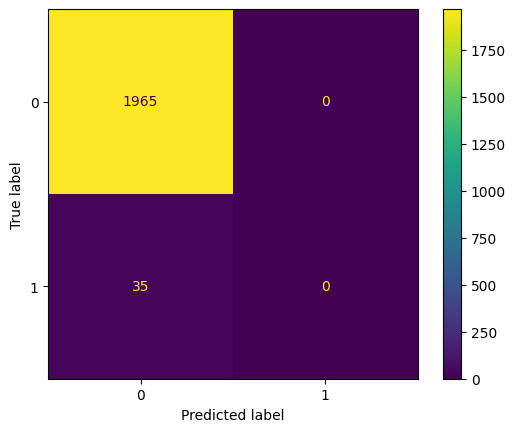

Precision: 0.0
Recall: 0.0
TP score: 0.0
TN score: 1.0
F1 score: 0.0


c:\Users\mmaru\Desktop\Dev Workshop\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [12]:
sample_df = get_shuffled_df_head(clean_df, 'abstract', 'relevance', 10000)
x_train, x_test, y_train, y_test, lr_model = test_logistic_regression(x=sample_df[['abstract']],
                         y=sample_df[['relevance']].to_numpy(),
                         x_preprocess_func=to_tf_idf,
                         test_size=0.2,
                         use_pca=True,
                         pca_components=500,
                         return_data= True)




In [13]:
import lime
import lime.lime_tabular


def lime_explain_lr(x, x_train, x_test, y_test, model):

    #Acquiring vectorizer
    x = sample_df[['abstract']]
    tokens = x.apply(pipeline_func, axis=1)
    vectorizer = TfidfVectorizer(min_df=2)
    vectorizer.fit_transform(tokens).toarray()

    #Creating lime instance
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=x_train,
        feature_names=vectorizer.get_feature_names_out(),
        class_names=['Non-Relevant', 'Relevant'],
        verbose = True,
        mode='classification'
    )

    #random sample from test set explained
    sample_index = np.random.randint(low= 0, high = x_test.shape[0])

    explanation = lime_explainer.explain_instance(
        data_row=x_test[sample_index],
        predict_fn=model.predict_proba,
    )
    explanation.show_in_notebook(show_table = True)
    print(sample_index)
    explanation.as_list()
    if y_test[sample_index] == 0:
        label = "Non-relevant"
    else:
        label = "Relevant"

    
    print("True label:", label)



In [14]:
lime_explain_lr(model = lr_model, x_train=x_train, x_test=x_test, y_test= y_test, x=sample_df[['abstract']])

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Intercept 0.022011983319225208
Prediction_local [0.01616065]
Right: 0.014268020137275211


1302
[ 1.92084418e-01 -1.04175419e-01 -1.90095398e-02  1.82301072e-02
 -3.34134760e-02 -1.74159830e-02  3.40616459e-03 -4.05435733e-02
  1.16492780e-02  4.54423875e-02 -2.82251002e-02 -2.44048127e-02
 -4.71373438e-04 -1.48946507e-03 -1.28959501e-02  9.56291436e-02
 -5.49252406e-02 -3.19816078e-02  1.01053213e-01  4.31542449e-04
  5.82956732e-02  4.68246166e-02  1.06614852e-02 -1.29876781e-02
 -2.09789150e-03 -7.28158860e-04 -2.78708602e-02  5.60145967e-02
 -2.72583625e-02 -1.16261504e-02 -8.22408162e-03  2.89670869e-02
 -5.09513427e-02 -4.52582087e-02 -1.04203739e-02  1.39956290e-02
 -2.91793617e-02  3.79997682e-02  4.08027712e-02  2.75017000e-02
 -4.48909731e-02  2.09933014e-02  1.51770423e-02  7.88234019e-02
 -2.21981310e-03  4.74361576e-02  8.01289284e-02 -6.03181118e-02
  5.10946488e-02  1.99149158e-02  3.32355359e-02  4.38514899e-02
 -6.74452185e-02  4.74333032e-03  1.08796837e-01  8.66917426e-03
  1.97448346e-02  3.21805912e-02  4.57721906e-02 -2.67349250e-02
 -1.07092114e-02  3.

In [32]:
x = sample_df[['abstract']]
tokens = x.apply(pipeline_func, axis=1)
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit_transform(tokens).toarray()

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
"""


def shap_explain_lr(x, x_train, x_test, y_test, model, sample_idx, vectorizer):

    #Initialize SHAP Explainer
    explainer = shap.Explainer(model, x_train, feature_names = vectorizer.get_feature_names_out())

    #Sample chosen
    sample_index = sample_idx
    print(sample_index)
    sample = x_test[sample_index]
    print(sample_index)

    #Calculate SHAP values for the selected sample
    shap_values = explainer.shap_values(sample)

    # Visualize the explanation
    #shap.initjs()

    #shap.plots.text(shap_values[:,:, :])

    # Print true label
    true_label = y_test[sample_index]
    print(f"True label: {true_label}")
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values,
        features=sample
        #feature_names=vectorizer.get_feature_names_out()
    )
"""

In [51]:
import shap


explainer = shap.Explainer(lr_model, x_train, feature_names=vectorizer.get_feature_names_out())


sample_index = 1302 #same as in LIME
#print(sample_index)
sample = x_test[sample_index]
# Calculate SHAP values for the selected sample
shap_values = explainer.shap_values(sample)
#print(shap_values)

print("Real value: ", y_test[sample_index])
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=sample

)

#shap.plots.text(shap_values)

Real value:  0


In [ ]:
#shap_explain_lr(model = lr_model, x_train=x_train, x_test=x_test, y_test= y_test, x=sample_df[['abstract']], sample_idx = 1302, vectorizer = vectorizer)

1302
1302
True label: 0


In [17]:
import numpy as np
import torch
import torch.nn as nn
import warnings
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
from tqdm.notebook import tqdm


class TextCleaner:
    def __init__(self, stopwords):
        self.stopwords = stopwords

    def clean(self, text):
        text = text.lower()
        text = re.sub(r'[^a-zA-Z?.!,¿]+', ' ', text)
        text = re.sub(r'http\S+', '', text)
        text = re.compile(r'<.*?>').sub(r'', text)

        punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
        for p in punctuations:
            text = text.replace(p, '')

        text = [word.lower() for word in text.split() if word.lower() not in self.stopwords]
        return ' '.join(text)


class FineTunedLLM:
    def __init__(self, device, class_weights=None):
        self.device = device
        self.class_weights = class_weights
        if not self.class_weights == None:
            self.class_weights = self.class_weights.to(self.device)

        self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                  num_labels = 2,
                                                                  output_attentions = False,
                                                                  output_hidden_states = False).to(self.device)

    def train(self, train_loader, epochs):
        self.model.train()
        optimizer = AdamW(self.model.parameters(), lr=2e-5)

        for epoch_i in range(epochs):
            print('')
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')
            for batch in tqdm(train_loader):
                b_input_ids = batch[0].to(self.device)
                b_input_mask = batch[1].to(self.device)
                b_labels = batch[2].to(self.device)

                optimizer.zero_grad()
                output = self.model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)

                loss = output.loss if self.class_weights == None else self._weighted_loss(output.logits, b_labels)
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

    def predict(self, test_loader):
        self.model.eval()

        predictions = []
        true_labels = []

        for batch in tqdm(test_loader):
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].numpy().flatten()

            with torch.no_grad():        
                output = self.model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask)

                logits = output.logits.detach().cpu().numpy()
                pred_flat = np.argmax(logits, axis=1).flatten()

                predictions.extend(list(pred_flat))
                true_labels.extend(list(b_labels))

        return np.array(predictions), np.array(true_labels)

    def _weighted_loss(self, logits, labels):
        ce_loss = nn.CrossEntropyLoss(weight=self.class_weights)
        return ce_loss(logits, labels)


class LLMDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

        eng_stopwords = set(stopwords.words('english'))
        self.text_cleaner = TextCleaner(eng_stopwords)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cleaned_text = self.text_cleaner.clean(self.df.iloc[idx, 0])
        x_input_ids, x_attention_mask = self._get_input_ids_with_attention_mask(cleaned_text)
        y_label = self.df.iloc[idx, 1]

        return x_input_ids, x_attention_mask, y_label

    def _get_input_ids_with_attention_mask(self, text):
        encoded_dict = self.tokenizer.encode_plus(text,
                                             add_special_tokens = True,
                                             max_length = 512,
                                             truncation=True,
                                             pad_to_max_length = True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
        return encoded_dict['input_ids'][0], encoded_dict['attention_mask'][0]


def get_train_test_datasets(df, test_size_percentage):
    train_size = int(len(df) * (1 - test_size_percentage))
    train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

    return LLMDataset(train_df), LLMDataset(test_df)


In [18]:
def test_llm(df, test_size, batch_size, epochs, device, class_weights=None):
    train_set, test_set = get_train_test_datasets(df, test_size)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    model = FineTunedLLM(device, class_weights)
    model.train(train_loader, epochs)

    y_pred, y_true = model.predict(test_loader)
    show_scores(y_true, y_pred)

    return train_loader, test_loader, model


**LLM without applying Class-Imbalance algorithms**

In [19]:
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

sample_df = get_shuffled_df_head(clean_df, 'abstract', 'relevance', 10000)

train_loader , test_loader, llm_model = test_llm(df=sample_df,
         test_size=0.2,
         batch_size=32,
         epochs=5,
         device=device)


cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 5 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]

: 

: 

### LIME for LLM

In [38]:

def gather_data_from_loader(loader):
    inputs, attentions, labels = [], [], []

    for batch in loader:
        inputs.append(batch[0])         # input_ids
        attentions.append(batch[1])     # attention_mask
        labels.append(batch[2])         # labels

    return torch.cat(inputs, dim=0), torch.cat(attentions, dim=0), torch.cat(labels, dim=0)

In [34]:
def lime_explain_llm(test_loader, model, sample_idx):
    x_test, attention_test, _ = gather_data_from_loader(test_loader)

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=x_test.cpu().numpy(),
        feature_names=[f"Token-{i}" for i in range(x_test.shape[1])],
        class_names=['Non-Relevant', 'Relevant'],
        verbose=True,
        mode='classification'
    )

    # Sample for analysis
    sample_text = x_test[sample_idx].cpu().numpy().reshape(1, -1)

    # Prediction function for LIME
    def predict_fn(inputs):
        inputs_tensor = torch.tensor(inputs, dtype=torch.long, device=model.device)
        #attention_mask = torch.ones_like(inputs_tensor, device=model.device)  # 
        logits = model.model(inputs_tensor).logits
        return torch.softmax(logits, dim=1).cpu().detach().numpy()

    # Explain instance
    explanation = lime_explainer.explain_instance(
        data_row=sample_text.flatten(),
        predict_fn=predict_fn
    )

    explanation.show_in_notebook(show_table=True)
    return explanation.as_list()



In [ ]:
lime_explain_llm(train_loader=train_loader, test_loader=test_loader, model = llm_model)

### SHAP for LLM

In [ ]:
import shap
import torch

def explain_with_shap(model, dataloader, sample_idx):

    # Gather input data from the DataLoader
    inputs, attentions, labels = gather_data_from_loader(dataloader)

    # Select the specific sample
    input_sample = inputs[sample_idx].unsqueeze(0).to(model.device)
    attention_sample = attentions[sample_idx].unsqueeze(0).to(model.device)
    true_label = labels[sample_idx].item()  # Get true label as integer

    print(f"True label: {true_label}")

    # Define a model prediction function for SHAP
    def model_predict(batch):
        batch_tensor = torch.tensor(batch, dtype=torch.long, device=model.device)
        attention_mask = torch.ones_like(batch_tensor, device=model.device)

        with torch.no_grad():
            outputs = model.model(batch_tensor, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()
        
        return logits

    # Initialize SHAP Explainer
    explainer = shap.Explainer(model_predict, input_sample.cpu().numpy())
    shap_values = explainer(input_sample.cpu().numpy())

    # Plot SHAP explanations
    shap.plots.text(shap_values[:,:,0]) 

    return shap_values

In [ ]:
sample_index = 1302
shap_values = explain_with_shap(llm_model, test_loader, sample_index)

## Task 4. Application of Class-Imbalance algorithms

In [58]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import numpy as np
from tqdm.notebook import tqdm


class DatasetPreprocessor:
    def __init__(self, df):
        self.df = df

    def downsample_by_quantity(self, quantity_percentage):
        majority_class_records = self.df[self.df['relevance'] == 0]
        remove_n = int(majority_class_records.shape[0] * quantity_percentage)
        drop_indices = np.random.choice(majority_class_records.index, remove_n, replace=False)
        self.df = self.df.drop(drop_indices)

        return self

    def downsample_by_queries(self, removed_query_ids):
        self.df = self.df[~self.df['query_id'].isin(removed_query_ids)]
        return self

    def upsample(self, upsample_config):
        minority_class_records = self.df[self.df['relevance'] == 1].sample(frac=1)
        mc_records_amount = minority_class_records.shape[0]
        upsample_ranges = {}
        start_ratio = 0.0
        for aug_key in upsample_config.keys():
            start_index, end_index = int(start_ratio * mc_records_amount), int((start_ratio + upsample_config[aug_key]) * mc_records_amount)
            upsample_ranges[aug_key] = (start_index, end_index)
            start_ratio += upsample_config[aug_key]

        if 'aug_contextual_word_embedding' in upsample_ranges:
            self._add_augmented_records(minority_class_records,
                                        'aug_contextual_word_embedding',
                                        upsample_ranges,
                                        naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action='substitute'))
        if 'aug_synonym' in upsample_ranges:
            self._add_augmented_records(minority_class_records,
                                        'aug_synonym',
                                        upsample_ranges,
                                        naw.SynonymAug(aug_src='wordnet'))
        if 'aug_spelling' in upsample_ranges:
            self._add_augmented_records(minority_class_records,
                                        'aug_spelling',
                                        upsample_ranges,
                                        naw.SpellingAug())
        if 'duplicate' in upsample_ranges:
            start_index, end_index = upsample_ranges['duplicate']
            self.df = self.df._append(minority_class_records.iloc[start_index:end_index, :], ignore_index=True)

        return self

    def _add_augmented_records(self, minority_class_records, aug_key, aug_ranges, augmentor):
        start_index, end_index = aug_ranges[aug_key]
        sample_records = minority_class_records.iloc[start_index:end_index, :]

        print(f'Augmenting abstracts ({aug_key})')
        augmented_abstracts = self._apply_by_chunks(sample_records['abstract'].to_numpy().ravel(), augmentor.augment)

        print(f'Augmenting titles ({aug_key})')
        augmented_titles = self._apply_by_chunks(sample_records['title'].to_numpy().ravel(), augmentor.augment)

        query_ids = ['CD_CONWE_AUG' for _ in range(start_index, end_index)]
        iters = doc_ids = [0 for _ in range(start_index, end_index)]
        relevances = [1 for _ in range(start_index, end_index)]

        augmented_samples = pd.DataFrame({
            'query_id': query_ids,
            'iter': iters,
            'doc_id': doc_ids,
            'relevance': relevances,
            'title': augmented_titles,
            'abstract': augmented_abstracts
        })
        self.df = self.df._append(augmented_samples, ignore_index=True)

    def _apply_by_chunks(self, records, apply_func, n_chunks=10):
        new_records = []
        for records_chunk in tqdm(np.array_split(records, n_chunks)):
            new_records += apply_func(records_chunk.tolist())

        return new_records


### 4.1 Testing downsampling

In [59]:
print(f'Records before: {clean_df.shape[0]}')

downsampled_df = DatasetPreprocessor(clean_df) \
    .downsample_by_queries(['CD011549', 'CD012019', 'CD009263', 'CD008643', 'CD008686']) \
    .downsample_by_quantity(0.75).df

print(f'Records after: {downsampled_df.shape[0]}')


Records before: 433910
Records after: 87819


#### 4.1.1 Logistic regression

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\mmaru\Desktop\Dev Workshop\project\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



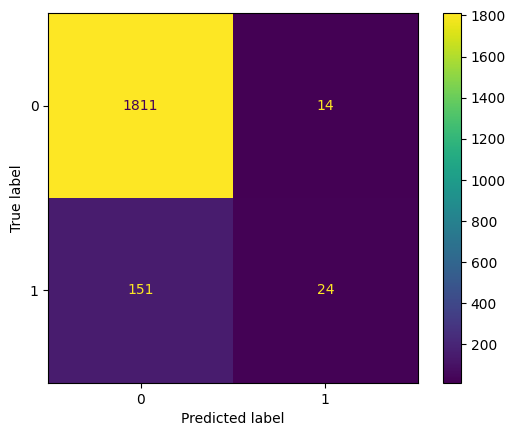

Precision: 0.631578947368421
Recall: 0.13714285714285715
TP score: 0.13714285714285715
TN score: 0.9923287671232877
F1 score: 0.22535211267605634


In [64]:
sample_df = get_shuffled_df_head(downsampled_df, 'abstract', 'relevance', 10000)

x_train, x_test, y_train, y_test, lr_model= test_logistic_regression(x=sample_df[['abstract']],
                         y=sample_df[['relevance']].to_numpy(),
                         x_preprocess_func=to_tf_idf,
                         test_size=0.2,
                         use_pca=True,
                         pca_components=500,
                         return_data = True)


In [67]:
lime_explain_lr(model = lr_model, x_train=x_train, x_test=x_test, y_test= y_test, x=sample_df[['abstract']])

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Intercept 0.1158398407646353
Prediction_local [0.03289377]
Right: 0.017468253472922458


1902
[ 2.50357395e-03  9.61951893e-02 -7.54946236e-03 -3.67910620e-02
  3.51599358e-02 -8.73514200e-03 -8.68991697e-02  2.69196380e-02
 -1.53372808e-02  8.53487470e-02 -1.39574901e-03  4.49160600e-02
 -4.24166271e-03  1.66545355e-02 -2.07544288e-02 -3.22732594e-02
 -1.31751153e-02  1.46866014e-02  8.65741808e-02 -2.23799355e-02
  8.55757824e-03  2.94051119e-02  3.04106991e-02  3.71562130e-02
  1.91737863e-02  5.95442945e-02  2.79049242e-02  1.09216111e-02
 -4.99441221e-02  3.27050118e-02  5.59591026e-03 -1.26470004e-05
  1.38892824e-02 -1.75177843e-02  2.61512752e-02  4.73691064e-03
  1.04544384e-02 -1.34906046e-02 -6.04546144e-03 -3.34694289e-02
 -3.99953818e-03 -2.77186483e-02  1.28887021e-02 -3.91643868e-02
 -1.85775003e-02  5.39126506e-03 -7.65514510e-03 -8.04152496e-03
  3.92197580e-02  3.62997317e-02 -3.09600608e-02 -2.61129964e-02
  1.45374125e-02 -1.47468698e-02 -3.20449899e-02 -3.43732300e-02
 -3.67716762e-02 -2.95447460e-02 -1.29007904e-02 -8.49207571e-03
 -3.72793479e-02 -2.

In [68]:
import shap

explainer = shap.Explainer(lr_model, x_train, feature_names=vectorizer.get_feature_names_out())


sample_index = 1302 #same as in LIME
#print(sample_index)
sample = x_test[sample_index]
# Calculate SHAP values for the selected sample
shap_values = explainer.shap_values(sample)
#print(shap_values)

print("Real value: ", y_test[sample_index])
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=sample

)

#shap.plots.text(shap_values)

Real value:  0


#### 4.1.2 LLM

cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 5 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 2 / 5 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 3 / 5 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 4 / 5 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 5 / 5 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

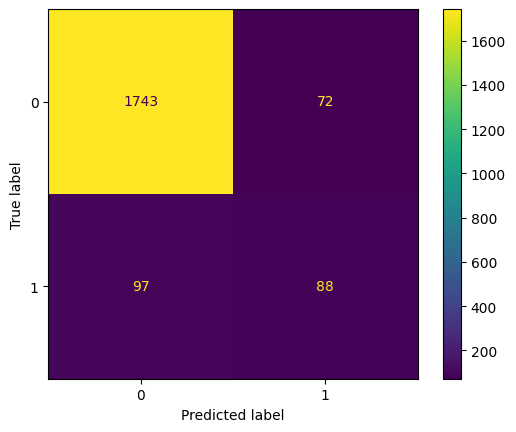

Precision: 0.55
Recall: 0.4756756756756757
TP score: 0.4756756756756757
TN score: 0.9603305785123967
F1 score: 0.510144927536232


In [18]:
warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

sample_df = get_shuffled_df_head(downsampled_df, 'abstract', 'relevance', 10000)

test_llm(df=sample_df,
         test_size=0.2,
         batch_size=32,
         epochs=1,
         device=device)


### 4.2 Testing Cost-sensitive learning

#### 4.2.1 Logistic regression

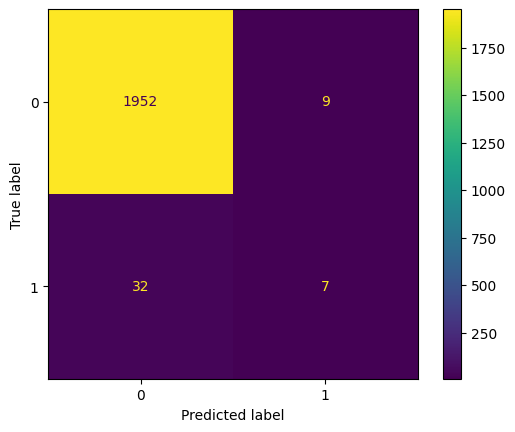

Precision: 0.4375
Recall: 0.1794871794871795
TP score: 0.1794871794871795
TN score: 0.9954105048444671
F1 score: 0.2545454545454545


In [21]:
sample_df = get_shuffled_df_head(clean_df, 'abstract', 'relevance', 10000)

test_logistic_regression(x=sample_df[['abstract']],
                         y=sample_df[['relevance']].to_numpy(),
                         x_preprocess_func=to_tf_idf,
                         test_size=0.2,
                         use_pca=True,
                         pca_components=500, class_weights={ 0: 1, 1: 5 })


#### 4.2.2 LLM

cuda:0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 2 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 3 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 4 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 5 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 6 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 7 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 8 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 9 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]


======== Epoch 10 / 10 ========
Training...


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

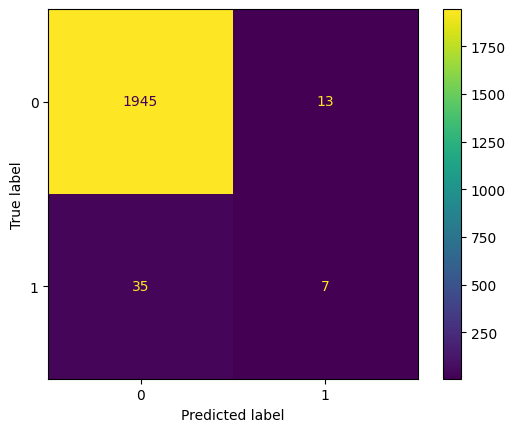

Precision: 0.35
Recall: 0.16666666666666666
TP score: 0.16666666666666666
TN score: 0.9933605720122574
F1 score: 0.22580645161290322


In [22]:
import torch

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

sample_df = get_shuffled_df_head(clean_df, 'abstract', 'relevance', 10000)

test_llm(df=sample_df,
         test_size=0.2,
         batch_size=32,
         epochs=10,
         device=device,
         class_weights=torch.Tensor([1, 5]))


### 4.3 Combining Downsampling, Upsampling by duplicating + augmentation and Cost-sensitive learning

In [69]:
def relevance_report(df):
    positive_relevance_records = df[df['relevance'] == 1].shape[0]
    negative_relevance_records = df[df['relevance'] == 0].shape[0]

    print(f'Positive relevance: {positive_relevance_records}')
    print(f'Negative relevance: {negative_relevance_records}')


print(f'Records before: {clean_df.shape[0]}')
relevance_report(clean_df)

balanced_df = DatasetPreprocessor(clean_df) \
    .downsample_by_queries(['CD011549', 'CD012019', 'CD009263', 'CD008643', 'CD008686']) \
    .downsample_by_quantity(0.8) \
    .upsample({
        'aug_contextual_word_embedding': 0.005,
        'aug_synonym': 0.2,
        'aug_spelling': 0.179,
        'duplicate': 0.3
    }).df

print(f'Records after: {balanced_df.shape[0]}')
relevance_report(balanced_df)


Records before: 433910
Positive relevance: 7987
Negative relevance: 425923


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\mmaru\Desktop\Dev Workshop\project\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning:

`huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mmaru\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development



config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Augmenting abstracts (aug_contextual_word_embedding)


  0%|          | 0/10 [00:00<?, ?it/s]

Augmenting titles (aug_contextual_word_embedding)


  0%|          | 0/10 [00:00<?, ?it/s]

Augmenting abstracts (aug_synonym)


  0%|          | 0/10 [00:00<?, ?it/s]

Augmenting titles (aug_synonym)


  0%|          | 0/10 [00:00<?, ?it/s]

Augmenting abstracts (aug_spelling)


  0%|          | 0/10 [00:00<?, ?it/s]

Augmenting titles (aug_spelling)


  0%|          | 0/10 [00:00<?, ?it/s]

Records after: 77220
Positive relevance: 13269
Negative relevance: 63951


#### 4.3.1 Logistic regression

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\mmaru\Desktop\Dev Workshop\project\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



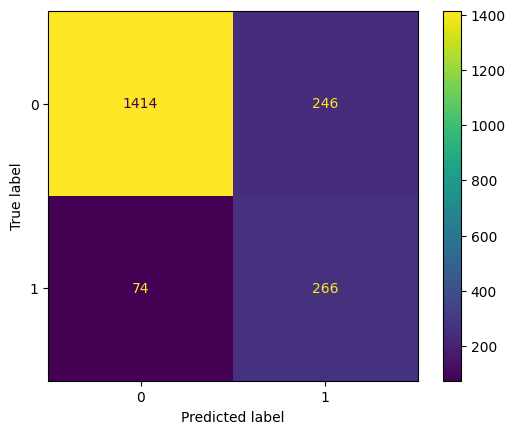

Precision: 0.51953125
Recall: 0.7823529411764706
TP score: 0.7823529411764706
TN score: 0.8518072289156626
F1 score: 0.6244131455399061


In [70]:
sample_df = get_shuffled_df_head(balanced_df, 'abstract', 'relevance', 10000)

x_train, x_test, y_train, y_test, lr_model = test_logistic_regression(x=sample_df[['abstract']],
                         y=sample_df[['relevance']].to_numpy(),
                         x_preprocess_func=to_tf_idf,
                         test_size=0.2,
                         use_pca=True,
                         pca_components=500, class_weights={ 0: 1, 1: 5 },
                         return_data= True)


#### LIME & SHAP

In [72]:
lime_explain_lr(model = lr_model, x_train=x_train, x_test=x_test, y_test= y_test, x=sample_df[['abstract']])

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Intercept 0.3439810471873296
Prediction_local [0.45039501]
Right: 0.18942684249473515


668
[ 6.94536744e-02 -5.47578942e-02 -4.35433303e-02 -3.46285650e-02
 -3.19197550e-02  3.24320667e-02 -2.22765095e-02  9.98594955e-02
 -1.35945001e-02  5.29818618e-03  2.78973922e-02  1.57891795e-02
  3.58279607e-02  6.76373702e-02 -6.91122219e-02  2.24857240e-02
  1.93930614e-03  6.69822608e-02 -2.39695078e-02  3.54856927e-02
  7.82349715e-02 -3.91456797e-02 -5.15391277e-03 -2.49656543e-02
 -1.49118629e-02 -4.31255101e-03  4.48410876e-03 -4.14694035e-02
 -3.08264669e-03 -9.75031444e-03 -2.60410331e-02 -8.22708243e-02
  1.43364378e-02  7.13598723e-02 -5.09163819e-02  7.25760002e-02
 -1.69257739e-02 -4.23350893e-02  1.93808060e-02 -5.38849140e-02
  3.56935783e-04  2.44898977e-03  2.41401411e-02  7.10663840e-02
 -1.64201816e-02 -1.88863994e-02  2.59629602e-02 -4.15204454e-02
 -2.98414339e-02 -7.12815041e-02 -4.32558226e-02  1.35403980e-02
  4.37149768e-03 -5.92436995e-03  4.15558063e-03  1.67744094e-02
 -1.04597591e-02  4.89039511e-02 -1.01641355e-02 -2.73306012e-02
  4.50368076e-02  6.1

In [75]:
import shap

x = sample_df[['abstract']]
tokens = x.apply(pipeline_func, axis=1)
vectorizer = TfidfVectorizer(min_df=2)
vectorizer.fit_transform(tokens).toarray()

explainer = shap.Explainer(lr_model, x_train, feature_names=vectorizer.get_feature_names_out())


sample_index = 668  #same as in LIME
#print(sample_index)
sample = x_test[sample_index]
# Calculate SHAP values for the selected sample
shap_values = explainer.shap_values(sample)
#print(shap_values)

print("Real value: ", y_test[sample_index])
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=sample

)

#shap.plots.text(shap_values)

C:\Users\mmaru\AppData\Local\Temp\ipykernel_15272\33430639.py:85: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Real value:  0


#### 4.3.2 LLM

In [74]:
import torch

#warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()

sample_df = get_shuffled_df_head(balanced_df, 'abstract', 'relevance', 10000)

test_llm(df=sample_df,
         test_size=0.2,
         batch_size=32,
         epochs=1,
         device=device,
         class_weights=torch.Tensor([1, 5]))


cuda:0


NameError: name 'test_llm' is not defined

In [78]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aai', ..., 'μmol', '₄₀', '₄₂'], dtype=object)